In [1]:
## Import cell
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import Omelyan_SST_Solver as SST

The point of this notebook is to implement an efficient computational technique that allows us to take a trajectory of a particle for a given set of initial conditions and determine if the orbit is ordered or chaotic (whether or not a small perturbation in the initial conditions will give a significantly different trajectory).

One of the most common ways to determine and classify an trajectory as ordered or chaotic is by evaluating the Lyapunov exponent (see Skokos and Manos 2016 or https://en.wikipedia.org/wiki/Lyapunov_exponent).

However, for this project, I chose to implement an alternative to the Lyapunov coefficient as an indicator of chaos that is often considered more efficient: the Smaller Alignment Index (or SALI), introduced by Skokos in 2001.

The procedure developed by Skokos is as follows:

Given an initial condition for the system, an associated point in phase space that has a slightly different set of initial conditions can be described by a deviation vector, defined as:

$\mathbf{w} \equiv (\delta x, \delta y, \delta p_x, \delta p_y)$

This deviation vector evolves in time according to the variational equations

$\dot{(\delta x)} = \delta \dot{x}$

$\dot{(\delta y)} = \delta \dot{y}$

$\dot{(\delta p_x)} = - \frac{\partial^2 V}{\partial x^2} \delta x - \frac{\partial^2 V}{\partial x \partial y} \delta y = - (1 + 2y) \delta x - 2x \delta y$

$\dot{(\delta p_y)} = - \frac{\partial^2 V}{\partial y \partial x} \delta x - \frac{\partial^2 V}{\partial y^2} \delta y = - 2x \delta x - (1 - 2y) \delta y$

(see Zotos 2015). Now, given two distinct deviation vectors $\mathbf{w}_1$ and $\mathbf{w}_2$ that initially point in two random directions in phase space and evolve in time by the equations above, the Smaller Alignment Index as a function of time is given by

$SALI(t) = min\{d_{+}, d_{-}\}$

with the alignment indices $d_+$ and $d_-$ defined as the sum and difference of the _normalized_ deviation vectors:

$d_{\pm} \equiv |\hat{\mathbf{w}}_1(t) \pm \hat{\mathbf{w}}_2(t)|$

In his 2001 paper, Skokos explains that if an orbit is ordered, the two deviation vectors should become tangent to the torus in phase space on which the orbit is confined to. In this ordered case $d_+$ and $d_-$ will tend to positive values between 0 and 2. Conversely, a chaotic orbit would have SALI(t) tend to 0 over time.

So ulitimately, a given orbit can be classified as either ordered or chaotic simply by calculating SALI(t) and seeing if it tends to zero or not. If SALI(t) for an orbit appears to clearly be going toward zero, then an orbit is chaotic.

To implement this technique, I wrote a function below that utilizes QPQ leapfrog symplectic integration to calculate the time evolution of two initial deviation vectors for a given Henon-Heiles orbit.

In [2]:
def calc_SALI(t, x, y, w1_0=[-.001, 0, 0, 0], w2_0=[0, 0, 0, -.001]):
    """
    Given a numerical solution for the trajectory of an orbit and two initial deviation vectors,
    find the Smaller Alignment Index (SALI) for that orbit as a function of time.
    
    Inputs:
        - t, x, y: the numerical solution for the trajectory (and associated time) for a
          Henon-Heiles orbit (numpy arrays, all the same length)
        - w1_0, w2_0: the initial deviation vectors from the initial conditions in phase space.
          They can point in any arbitrary direction in phase space (but for an actual calculation
          they should be orthonormal to one another so that SALI(t=0) is nonzero.)
          wi = [dx, dy, dpx, dpy] (numpy arrays of length 4)

    Returns:
        - SALI: Smaller Alignment Index over the course of the calculated orbit for the two deviation vectors
          (numpy array, same length as t, x, and y)
    
    """
    w1 = np.zeros((len(t), 4), dtype=float)
    w2 = np.zeros((len(t), 4), dtype=float)
    w1[0] = w1_0
    w2[0] = w2_0
    
    dt = t[1] - t[0]
    for i in range(len(t)-1):
        # QPQ leapfrog symplectic integrator to update w1 and w2
        # update "positions" by dt/2
        dx1_half = w1[i, 0] + dt/2 * w1[i, 2]
        dy1_half = w1[i, 1] + dt/2 * w1[i, 3]
        dx2_half = w2[i, 0] + dt/2 * w2[i, 2]
        dy2_half = w2[i, 1] + dt/2 * w2[i, 3]
        # update "momenta" with half-updated positions
        w1[i+1, 2] = w1[i, 2] + dt * (-(1 + 2*y[i])*dx1_half - 2*x[i]*dy1_half)
        w1[i+1, 3] = w1[i, 3] + dt * (-2*x[i]*dx1_half - (1-2*y[i])*dy1_half)
        w2[i+1, 2] = w2[i, 2] + dt * (-(1 + 2*y[i])*dx2_half - 2*x[i]*dy2_half)
        w2[i+1, 3] = w2[i, 3] + dt * (-2*x[i]*dx2_half - (1-2*y[i])*dy2_half)
        # update "positions" by dt/2 with updated "momenta"
        w1[i+1, 0] = dx1_half + dt/2 * w1[i+1, 2]
        w1[i+1, 1] = dy1_half + dt/2 * w1[i+1, 3]
        w2[i+1, 0] = dx2_half + dt/2 * w2[i+1, 2]
        w2[i+1, 1] = dy2_half + dt/2 * w2[i+1, 3]
    
    # normalize w1 and w2
    w1_mag = np.sqrt(np.sum(w1**2, axis=1))
    w2_mag = np.sqrt(np.sum(w2**2, axis=1))
    # I need to repeat these arrays 4 times, so I can divide all 4 components of w's by their magnitude to normalize them
    w1_mag = np.repeat(w1_mag[...,np.newaxis], 4, axis=1)
    w2_mag = np.repeat(w2_mag[...,np.newaxis], 4, axis=1)
    
    w1_hat = w1/w1_mag
    w2_hat = w2/w2_mag
    
    d_plus = w1_hat + w2_hat
    d_minus = w1_hat - w2_hat
    d_plus_mag = np.sqrt(np.sum(d_plus**2, axis=1))
    d_minus_mag = np.sqrt(np.sum(d_minus**2, axis=1))
    
    SALI = np.minimum(d_plus_mag, d_minus_mag)
    return SALI

This is kind of a difficult function to test. I just made sure it gave what I would expect for a few fairly trivial cases where the particle stays at the origin at all times.

A couple cases tested below (for all of them $x(t) = y(t) = 0$):
 - For $\mathbf{w}_{1,0}$ and $\mathbf{w}_{2,0}$ orthogonal to each other, SALI should be $\sqrt{2}$ at time 0 because $d_+ = d_- = \sqrt{2}$.
 - For $\mathbf{w}_{2,0} = c \ \mathbf{w}_{1,0}$ for some constant c, either $d_{+}$ or $d_{-}$ will be zero so SALI should be zero at time 0.
 - For $\mathbf{w}_{1,0}$ = $\mathbf{w}_{2,0}$, SALI(t) should equal 0 at all times

In [3]:
t_test = np.linspace(0, 10, 11)
x_test = np.zeros_like(t_test)
y_test = np.zeros_like(t_test)

SALI_test_1 = calc_SALI(t_test, x_test, y_test, [1,0,0,0], [0,1,0,0]) # w1, w2 orthogonal. d+/-=[1,+/-1,0,0]; SALI = sqrt(2)
SALI_test_2 = calc_SALI(t_test, x_test, y_test, [1,0,0,0], [-0.4,0,0,0]) # w2 = c*w1 d+ = [0,0,0,0] d- = [2,0,0,0]; SALI = 0 
SALI_test_3 = calc_SALI(t_test, x_test, y_test, [1,0,0,0], [1,0,0,0]) # w1 = w2 d+=[2,0,0,0] d-=[0,0,0,0]; SALI = 0 at all t
print(SALI_test_1)
print(SALI_test_2)
print(SALI_test_3)

npt.assert_allclose(SALI_test_1[0], np.sqrt(2))
npt.assert_allclose(SALI_test_2[0], 0)
npt.assert_allclose(SALI_test_3, np.zeros_like(t_test))

[1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now, I want to implement this function and calculate SALI(t) for several Henon-Heiles orbits. The goal with this technique is to be able to classify any Henon-Heiles orbit as ordered or chaotic. The parameter space is quite complicated, so to keep things tractable I stuck to a small region in the parameter space. First, I'll look at orbits with only one nonzero initial parameter: $x_0$. Below, I calculated and plotted SALI(t) for a few different values, of $x_0$ to be able to see qualitatively how SALI(t) differs between ordered and chaotic orbits.

dt = 0.01000010000100001


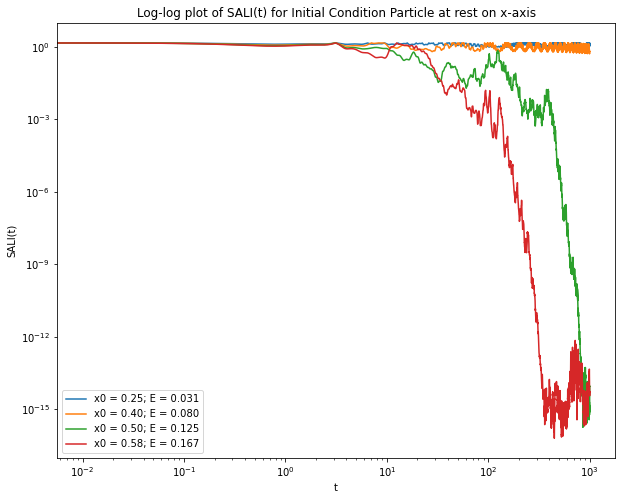

In [5]:
t = np.linspace(0, 1000, 100000)
print('dt =', t[1]- t[0])

# x0, y0, px0, py0
initial_conditions = [[1/4, 0, 0, 0],
                      [2/5, 0, 0, 0],
                      [1/2, 0, 0, 0],
                      [1/np.sqrt(3), 0, 0, 0]] # largest value of x0 allowed. Gives E=1/6

plt.figure(figsize=(10,8))
for i in initial_conditions:
    x0, y0, px0, py0 = i[0], i[1], i[2], i[3]
    E = SST.E_HH(x0, y0, px0, py0)
    x, y, px, py = SST.solve(t, x0, y0, px0, py0, SST.dVHH_dx, SST.dVHH_dy)
    # make sure step size is small enough that energy is conserved throughout orbit
    npt.assert_allclose(0, np.max(np.abs(SST.E_HH(x, y, px, py) - E)), atol=1e-5)
    
    SALI = calc_SALI(t, x, y)
    plt.loglog(t, SALI, label='x0 = %.2f; E = %.3f' % (x0, E))
    plt.xlabel('t')
    plt.ylabel('SALI(t)')
    plt.title('Log-log plot of SALI(t) for Initial Condition Particle at rest on x-axis')
    plt.legend()

For the above four cases, two are ordered ($x_0 = \frac{1}{4}$ and $x_0 = \frac{2}{5}$) while the other two are chaotic ($x_0 = \frac{1}{2}$ and $x_0 = \frac{1}{\sqrt{3}}$).

It can be clearly seen from the plots that for the two chaotic orbits, SALI(t) trends significantly to zero over the course of the trajectory, falling to under $10^{-15}$ after only $10^{3}$ time units. This is easily contrasted with the ordered orbits, where SALI(t) oscillates around one. These results are consistent with the behavior of SALI(t) for chaotic and ordered orbits for Henon-Heiles orbits (see Zotos 2015).

Note: orbits with higher energy are the ones that tend to more likely show chaotic behavior. 

Now, to actually explore the parameter space with this method and classify orbits as either ordered or chaotic. Following Zotos's paper, I will classify a given orbit as chaotic if SALI(t) drops below $10^{-8}$ over the course of the calculation.

I will do two different parameter explorations to look for a transition from ordered to chaotic behavior:

  1. I will have all parameters besides $x_0$ be fixed at 0, and vary $x_0$ from 0 to it's maximally energetically allowed value (for a bound orbit) of $\frac{1}{\sqrt{3}}$.
  2. I will fix $x_0 = \frac{1}{4}$ and vary $p_{0y}$ from 0 to it's maximally allowed value of $\sqrt{\frac{13}{48}}$.
  
The goal in both of these calculations is to determine the value of the initial conditions where the orbit first changes from ordered to chaotic (each cell should take ~1 minute to run).

In [6]:
t = np.linspace(0, 1000, 100000)
print('dt =', t[1]- t[0])

x0s = np.linspace(0, np.sqrt(1/3), 20) # sqrt(1/3) is the max value of x0 allowed for Gives E=1/6

Energies = np.zeros_like(x0s, dtype=bool)
is_chaotic = np.zeros_like(x0s, dtype=bool)

for i in range(len(x0s)):
    x0, y0, px0, py0 = x0s[i], 0, 0, 0
    E = SST.E_HH(x0, y0, px0, py0)
    Energies[i] = E
    x, y, px, py = SST.solve(t, x0, y0, px0, py0, SST.dVHH_dx, SST.dVHH_dy)
    # make sure step size is small enough that energy is conserved throughout orbit
    npt.assert_allclose(0, np.max(np.abs(SST.E_HH(x, y, px, py) - E)), atol=1e-5) 
    SALI = calc_SALI(t, x, y)
    if np.min(SALI) < 1e-8:
        is_chaotic[i] = True
        
print(is_chaotic)
chaotic_x0s = x0s[is_chaotic]
print('first value of x0 that is chaotic: %.3f' % chaotic_x0s[0])
print('associated energy: %.3f' % SST.E_HH(chaotic_x0s[0], 0, 0, 0))

dt = 0.01000010000100001
[False False False False False False False False False False False False
 False False False  True  True  True  True  True]
first value of x0 that is chaotic: 0.456
associated energy: 0.104


In [7]:
t = np.linspace(0, 1000, 100000)
print('dt =', t[1]- t[0])

py0s = np.linspace(0, np.sqrt(13/48), 20) # sqrt(13/48) is the max value of py0 allowed for x0=1/4. Gives E=1/6

Energies = np.zeros_like(py0s, dtype=bool)
is_chaotic = np.zeros_like(py0s, dtype=bool)

for i in range(len(py0s)):
    x0, y0, px0, py0 = 1/4, 0, 0, py0s[i]
    E = SST.E_HH(x0, y0, px0, py0)
    Energies[i] = E
    x, y, px, py = SST.solve(t, x0, y0, px0, py0, SST.dVHH_dx, SST.dVHH_dy)
    # make sure step size is small enough that energy is conserved throughout orbit
    npt.assert_allclose(0, np.max(np.abs(SST.E_HH(x, y, px, py) - E)), atol=1e-5) 
    SALI = calc_SALI(t, x, y)
    if np.min(SALI) < 1e-8:
        is_chaotic[i] = True
        
print(is_chaotic)
chaotic_py0s = py0s[is_chaotic]
print('first value of py0 that is chaotic: %.3f' % chaotic_py0s[0])
print('associated energy: %.3f' % SST.E_HH(chaotic_py0s[0], 0, 0, 0))

dt = 0.01000010000100001
[False False False False False False False False False False False False
 False False False False  True  True  True  True]
first value of py0 that is chaotic: 0.438
associated energy: 0.096


Only 20 points are sampled along the two lines of initial conditions above. This is to keep the computation time down when grading. To be a little more thorough, I also redid the calculations with more points sampled (changing the number of points in x0s and py0s above)

Using 200 points instead of 20 for each, I end up with

$x_0 = 0.450$ ($E = 0.101$) is the lowest value such that an orbit is chaotic with the other three parameters set to 0.

$p_{0y} = 0.420$ ($E = 0.090$) is the lowest value for $p_{0y}$ with $x_0 = \frac{1}{4}$ such that the orbit is chaotic.

As mentioned before, I have only explored a very small subset of the parameter space here. The point is that this method can be applied to any orbit for the Henon-Heiles potential, so _any_ set of initial conditions can be efficiently classified as either ordered or chaotic for this system, which was my intent with this project.